## Situacion Probelma 2
**Rodrigo Lopez Murguia**

**Victor Misael Escalante Alvarado**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
import heapq

### Declaracion de clases usadas

Declaracion de la clase nodo y arista para represetar las coordenadas y graficarla

In [2]:
class Node :
    def __init__(self, node_id, x, y, is_source):
        self.node_id = node_id
        self.x = x
        self.y = y
        self.is_source = is_source

        self.neighbours = []
        self.distances = []
        self.sector = None
        self.fuente = None
        self.distance_to_source = None
        self.sector = None
        self.color = None
        self.capacity = 0

In [3]:
class Tuberia :
    def __init__(self, start_node, end_node, capacity):
        self.start_node = start_node
        self.end_node = end_node
        self.capacity = float(capacity)

        self.length = 0
        self.open = True


### Lectura de Instancias

#### Funcion para reformatear un archivo de texto
Es la preparacion del archivo a partir de los .txt en donde se genera una lista con los nodos , las aristas y la oficina.

In [4]:
def file_prep(route):
    '''
    num_nodos num_aristas
    [NODES]
    num_nodo x y isfont
    [EDGES]
    num_nodo1 num_nodo2 capacidad
    [OFFICE]
    num_nodo
    [NEW_NODEs]
    x y diametro
    '''
    with open(route) as file:
        # lista de nodos
        nodes = {}
        tuberias = []
        new_nodes = []

        lines = file.readlines()

        num_nodos = int(lines[0].split(" ")[0])
        num_aristas = int(lines[0].split(" ")[1])

        # Llenamos la lista de nodos
        for i in range(2, 2 + num_nodos):
            lines[i] = lines[i].split(" ")
            node_id = int(lines[i][0])
            nodes[node_id] = Node(node_id, float(lines[i][1]), float(lines[i][2]), int(lines[i][3]))
            # Inicializar vecinos para cada nodo
            nodes[node_id].neighbors = []

        # Llenamos la lista de tuberías y actualizamos vecinos
        for i in range(4 + num_nodos, 4 + num_nodos + num_aristas - 1):
            lines[i] = lines[i].split(" ")
            nodo1 = int(lines[i][0])
            nodo2 = int(lines[i][1])
            capacidad = float(lines[i][2])

            new_tuberia = Tuberia(nodo1, nodo2, capacidad)
            # Crear la tubería


            # Calcular la distancia (si es necesaria)
            distancia = ((nodes[nodo1].x - nodes[nodo2].x) ** 2 + (nodes[nodo1].y - nodes[nodo2].y) ** 2) ** 0.5
            new_tuberia.length = distancia

            tuberias.append(new_tuberia)
            # Actualizar vecinos
            nodes[nodo1].neighbors.append((nodo2, distancia))
            nodes[nodo2].neighbors.append((nodo1, distancia))  # Si el grafo es no dirigido

        # Oficina
        office_node = int(lines[4 + num_nodos + num_aristas])

        # Nuevos nodos
        for i in range(6 + num_nodos + num_aristas, len(lines)):
            lines[i] = lines[i].split(" ")

            new_node = Node(-1, float(lines[i][0]), float(lines[i][1]), 0)
            new_node.capacity = float(lines[i][2])
            new_nodes.append(new_node)

    # Retornar los nodos como lista, además de las tuberías, nuevos nodos y la oficina
    return list(nodes.values()), tuberias, new_nodes, office_node


###3. Sectorización de la topología

In [5]:
def dijkstra(nodos, aristas, nodoOrigen, fuente):
    distancias = [float('inf')] * max(nodos)
    distancias[nodoOrigen - 1] = 0
    procesado = [False] * max(nodos)
    predecesor = [-1] * max(nodos)
    fila = []
    heapq.heappush(fila, (0, nodoOrigen))
    while fila:
        distanciaActual, nodoActual = heapq.heappop(fila)
        if procesado[nodoActual - 1]:
            continue
        procesado[nodoActual - 1] = True
        for vecino, _ in aristas[nodoActual]:
            distanciaNueva = distanciaActual + distancia_entre_nodos(nodos, nodoActual, vecino)
            if distanciaNueva < distancias[vecino - 1]:
                distancias[vecino - 1] = distanciaNueva
                predecesor[vecino - 1] = nodoActual
                if not procesado[vecino - 1]:
                    heapq.heappush(fila, (distanciaNueva, vecino))
    DistanciaTotal = distancias[fuente - 1]
    return DistanciaTotal if DistanciaTotal != float('inf') else None

In [6]:
def sectorize(nodos, tuberias):
    fuentes = [node for node in nodos if node.is_source == 1]

    # Diccionario predecesores
    node_to_source = {}

    for node in nodos:
        if node.is_source == 1:
            node_to_source[node.node_id] = node.node_id  # Ignorar fuente
        else:
            # Seleccionar la fuente más cercana
            distancias = [
                (fuente.node_id, np.sqrt((node.x - fuente.x)**2 + (node.y - fuente.y)**2))
                for fuente in fuentes
            ]
            fuente_cercana = min(distancias, key=lambda x: x[1])
            node_to_source[node.node_id] = fuente_cercana[0]

    # Identificar las tuberías a cerrar
    tuberias_cerradas = []
    for tuberia in tuberias:
        start_sector = node_to_source[tuberia.start_node]
        end_sector = node_to_source[tuberia.end_node]

        # Si tubería conecta 2 sectores, cerrar
        if start_sector != end_sector:
            tuberias_cerradas.append(tuberia)

    sectores = defaultdict(list)
    for node_id, source_id in node_to_source.items():
        sectores[source_id].append(node_id)


    return sectores, tuberias_cerradas

###4. Frescura del Agua

In [7]:
#4. Frescura del agua
def frescura_agua(nodos, sectores):
    resultados = []

    for sector, nodos_del_sector in sectores.items():
        # Obtener la fuente del sector
        fuente = next(node for node in nodos if node.node_id == sector)
        nodo_mas_lejano = None
        distancia_maxima = -1

        for nodo_id in nodos_del_sector:
            nodo = next(node for node in nodos if node.node_id == nodo_id)

            # Calcular la distancia de la fuente a este nodo
            distancia = np.sqrt((nodo.x - fuente.x)**2 + (nodo.y - fuente.y)**2)

            # Actualizar el nodo más lejano si encontramos una mayor distancia
            if distancia > distancia_maxima:
                distancia_maxima = distancia
                nodo_mas_lejano = nodo

        # Almacenar el resultado para este sector
        resultados.append({
            "sector": sector,
            "fuente": fuente.node_id,
            "nodo_mas_lejano": nodo_mas_lejano.node_id,
            "distancia": distancia_maxima
        })

    return resultados

###5. Flujo maximo de cada sector

**Funciones de apoyo**

In [8]:
def bfs_flujo(residual, id_source, id_sink):
    # Inicializar
    queue = []
    visited = set()
    parent = {}

    # Inicializar
    queue.append(id_source)
    visited.add(id_source)
    parent[id_source] = None

    # BFS
    while queue:
        current_node = queue.pop(0)

        for neighbor, capacity in residual[current_node]:
            if neighbor not in visited and capacity > 0:
                queue.append(neighbor)
                visited.add(neighbor)
                parent[neighbor] = current_node

    # Reconstruir el camino
    if id_sink not in visited:
        return None

    path = []
    current_node = id_sink
    while current_node is not None:
        path.insert(0, current_node)
        current_node = parent[current_node]

    return path

def get_nodes_from_sector(nodos, ids):
    return [node for node in nodos if node.node_id in ids]

**Mas funciones**

In [9]:
def matris_adyacencia(nodos, tuberias, nodos_del_sector):
    # Crear matriz de adyacencia
    matriz = np.zeros((len(nodos_del_sector), len(nodos_del_sector)))

    # Crear diccionario de nodos
    node_dict = {node.node_id: i for i, node in enumerate(nodos_del_sector)}

    # Llenar la matriz
    for tuberia in tuberias:
        if tuberia.start_node in node_dict and tuberia.end_node in node_dict:
            i = node_dict[tuberia.start_node]
            j = node_dict[tuberia.end_node]

            matriz[i][j] = tuberia.capacity
            matriz[j][i] = tuberia.capacity

    return matriz


**Funcion de edmonds karp para el flujo maximo de un sector dado**

In [10]:
# Función para construir la red residual
def construir_red_residual(nodos, tuberias):
    red_residual = defaultdict(lambda: defaultdict(float))
    for tuberia in tuberias:
        red_residual[tuberia.start_node][tuberia.end_node] = tuberia.capacity
        red_residual[tuberia.end_node][tuberia.start_node] = 0  # Capacidad inversa inicial
    return red_residual

# Función de BFS para encontrar el camino aumentante
def bfs(red_residual, source_id, sink_id, parent):
    visited = {source_id}
    queue = deque([source_id])
    while queue:
        nodo_actual = queue.popleft()
        for vecino, capacidad in red_residual[nodo_actual].items():
            if vecino not in visited and capacidad > 0:
                parent[vecino] = nodo_actual
                visited.add(vecino)
                queue.append(vecino)
    return sink_id in visited

# Función de Edmonds-Karp para encontrar el flujo máximo
def edmonds_karp(nodos, tuberias, source_id, sink_id):
    red_residual = construir_red_residual(nodos, tuberias)
    parent = {}
    flujo_maximo = 0

    while bfs(red_residual, source_id, sink_id, parent):
        flujo_camino = float('inf')
        nodo_actual = sink_id

        while nodo_actual != source_id:
            flujo_camino = min(flujo_camino, red_residual[parent[nodo_actual]][nodo_actual])
            nodo_actual = parent[nodo_actual]

        nodo_actual = sink_id
        while nodo_actual != source_id:
            red_residual[parent[nodo_actual]][nodo_actual] -= flujo_camino
            red_residual[nodo_actual][parent[nodo_actual]] += flujo_camino
            nodo_actual = parent[nodo_actual]

        flujo_maximo += flujo_camino

    return flujo_maximo


**Funcion Principal**

In [11]:
from collections import deque
def flujo_maximo_fun(nodos, tuberias, nodos_del_sector, id_source, id_sink):
    # Crear matriz de adyacencia
    matriz = matris_adyacencia(nodos, tuberias, nodos_del_sector)

    # Verificar dimensiones de la matriz
    assert len(matriz) == len(nodos_del_sector), "Dimensiones de la matriz incorrectas."

    # Inicializar flujo
    flujo = 0
    # Crear red residual
    residual = matriz.copy()
    # Inicializar lista de padres
    parent = [-1] * len(nodos_del_sector)
    #
    node_dict = {node.node_id: i for i, node in enumerate(nodos_del_sector)}

    # Verificar que los nodos fuente y destino existen en el sector
    if id_source not in node_dict or id_sink not in node_dict:
        raise ValueError(f"El nodo fuente ({id_source}) o destino ({id_sink}) no están en nodos_del_sector.")

    # Función para realizar BFS en la red residual
    def bfs_residual(source, sink, parent):
        visited = [False] * len(nodos_del_sector)
        queue = [source]
        visited[source] = True

        while queue:
            u = queue.pop(0)

            if u >= len(residual):
                raise IndexError(f"Índice u={u} fuera del rango para residual de tamaño {len(residual)}")

            for v, capacity in enumerate(residual[u]):
                if v >= len(visited):
                    raise IndexError(f"Índice v={v} fuera del rango para visited de tamaño {len(visited)}")
                if not visited[v] and capacity > 0:
                    queue.append(v)
                    visited[v] = True
                    parent[v] = u

        return visited[sink]

    # Algoritmo de Edmonds-Karp
    while bfs_residual(node_dict[id_source], node_dict[id_sink], parent):
        path_flow = float('Inf')
        s = node_dict[id_sink]

        while s != node_dict[id_source]:
            path_flow = min(path_flow, residual[parent[s]][s])
            s = parent[s]

        v = node_dict[id_sink]
        while v != node_dict[id_source]:
            u = parent[v]
            residual[u][v] -= path_flow
            residual[v][u] += path_flow
            v = parent[v]

        flujo += path_flow

    return flujo


###6. Muestras de agua

In [12]:

#Exploración de grafo
def tsp(nodos, tuberias, office_node_id):

    lista_adyacencias = {}

    for node in nodos:
        lista_adyacencias[node.node_id] = []

    for tuberia in tuberias:
        lista_adyacencias[tuberia.start_node].append((tuberia.end_node, tuberia.length))
        lista_adyacencias[tuberia.end_node].append((tuberia.start_node, tuberia.length))

    #Recorrer todo el grafo
    current_node = office_node_id
    visited_nodes = set([office_node_id])
    predecesores = {}
    predecesores[current_node] = None
    path = [current_node]
    total_distance = 0
    # print("Ruta de exploracion:")
    # print("Visitando nodo", current_node, ", Distancia:",0)


    while len(visited_nodes) < len(nodos):
        neighbors = lista_adyacencias[current_node]
        neighbors = [(node, distance) for node, distance in neighbors if node not in visited_nodes]

        if len(neighbors) == 0:
            if predecesores[current_node] is None:
                break
            path.append(predecesores[current_node][0])
            total_distance += predecesores[current_node][1]
            # print("Regresando a", predecesores[current_node][0], ", Distancia:", predecesores[current_node][1])
            current_node = predecesores[current_node][0]

        else:
          # Buscar vecino más cercano y seleccionar ese
          nearest_neighbor = min(neighbors, key=lambda x: x[1])
          predecesores[nearest_neighbor[0]] = (current_node, nearest_neighbor[1])
          current_node = nearest_neighbor[0]
          # print("Visitando nodo", current_node, ", Distancia:",nearest_neighbor[1])
          total_distance += nearest_neighbor[1]
          visited_nodes.add(current_node)
          path.append(current_node)

    #Volver al inicio
    regreso, costo = buscar_camino_mas_cercano(lista_adyacencias, current_node, office_node_id)
    total_distance += costo
    # print("Comenzando Camino de Regreso...")
    for nodo in regreso:
        path.append(nodo)
        # print("Visitando Nodo", nodo)
    # print("Distancia Total Recorrida:", total_distance)

    return path, total_distance


def buscar_camino_mas_cercano(lista_adyacencias, start_node, end_node):
    import heapq

    # Distancias inicializadas a infinito
    distancias = {node: float('inf') for node in lista_adyacencias}
    distancias[start_node] = 0

    # Cola de prioridad para procesar los nodos
    priority_queue = [(0, start_node)]
    predecesores = {}

    while priority_queue:
        distancia_actual, nodo_actual = heapq.heappop(priority_queue)

        if nodo_actual == end_node:
            break

        for vecino, peso in lista_adyacencias[nodo_actual]:
            distancia_por_este_nodo = distancia_actual + peso
            if distancia_por_este_nodo < distancias[vecino]:
                distancias[vecino] = distancia_por_este_nodo
                predecesores[vecino] = nodo_actual
                heapq.heappush(priority_queue, (distancia_por_este_nodo, vecino))

    # Reconstruir el camino desde end_node hacia start_node
    camino = []
    nodo = end_node
    while nodo in predecesores:
        camino.append(nodo)
        nodo = predecesores[nodo]
    camino.append(start_node)
    camino.reverse()

    return camino, distancias[end_node]

###7. nuevas conexiones

Funcion para integrar un nodo a la red

In [13]:
def expansion_red(new_nodes, nodos, tuberias):

    for node_nuevo in new_nodes:

        node_nuevo.node_id = len(nodos)
        node_nuevo.is_source = 0

        closest_node = min(nodos, key=lambda node: np.sqrt((node.x - node_nuevo.x)**2 + (node.y - node_nuevo.y)**2))

        node_nuevo.neighbours.append(closest_node)
        closest_node.neighbours.append(node_nuevo)

        node_nuevo.distances.append(np.sqrt((node_nuevo.x - closest_node.x)**2 + (node_nuevo.y - closest_node.y)**2))
        closest_node.distances.append(np.sqrt((node_nuevo.x - closest_node.x)**2 + (node_nuevo.y - closest_node.y)**2))

        print(f"\tNuevo nodo en (x,y): ({node_nuevo.x},{node_nuevo.y}) se conecta con {closest_node.node_id} en (x,y) -> ({closest_node.x} , {closest_node.y})")

        tuberia_nuevva = Tuberia(node_nuevo.node_id, closest_node.node_id, node_nuevo.capacity)
        nodos.append(node_nuevo)
        tuberias.append(tuberia_nuevva)

    return nodos, tuberias

Funcion para generar un grafico de la red expandida

In [14]:
def plot_expanded_graph(ruta,nodos_limpio, tuberias, id_office):
    plt.figure(figsize=(7, 5))
    plt.title(ruta + "(despues de la expansion)")

    node_dict = {node.node_id: node for node in nodos_limpio}

    for node in nodos_limpio:
        if node.is_source == 1:
            plt.plot(node.x, node.y, 'ro', label="Fuente" if "Fuente" not in plt.gca().get_legend_handles_labels()[1] else "")
        elif node.node_id == id_office:
            plt.plot(node.x, node.y, 'mo', label="Oficina Central" if "Oficina Central" not in plt.gca().get_legend_handles_labels()[1] else "")
            plt.text(node.x, node.y, f'Oficina', color='black', fontsize=16)
        else:
            plt.plot(node.x, node.y, f'{Colors[idx]}o', label="Nodos Comunes" if "Nodos Comunes" not in plt.gca().get_legend_handles_labels()[1] else "")

    for tuberia in tuberias_limpio:

        nodo_inicial = node_dict[tuberia.start_node]
        nodo_final = node_dict[tuberia.end_node]

        plt.plot([nodo_inicial.x, nodo_final.x], [nodo_inicial.y, nodo_final.y], 'g', label="Tubería" if "Tubería" not in plt.gca().get_legend_handles_labels()[1] else "")
        plt.text((nodo_inicial.x + nodo_final.x) / 2, (nodo_inicial.y + nodo_final.y) / 2, f'{tuberia.length:.2f}', color='black', fontsize=6)

    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid()
    plt.savefig(Files_Titles[idx] + "_despues.png")
    plt.show()


## Algoritmo principal
Toma las instancias , las prepara y corre los algoritmos necesarios para reolver la problemática


			Procesando archivo: FOS



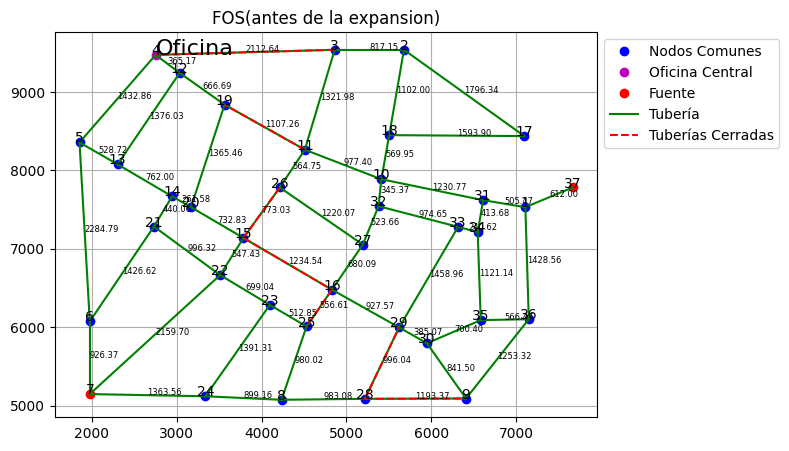


Agregando nuevos nodos:

	Nuevo nodo en (x,y): (7071.0,9055.0) se conecta con 17 en (x,y) -> (7099.51 , 8438.51)
	Nuevo nodo en (x,y): (1957.0,9160.0) se conecta con 5 en (x,y) -> (1852.75 , 8357.61)


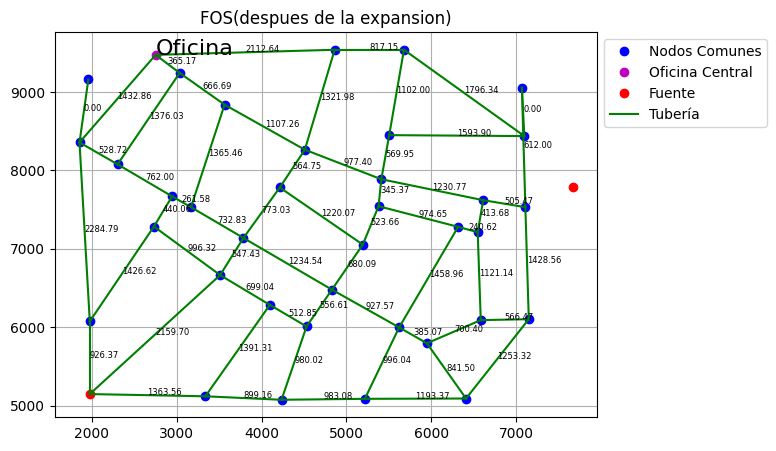


			Procesando archivo: HAN



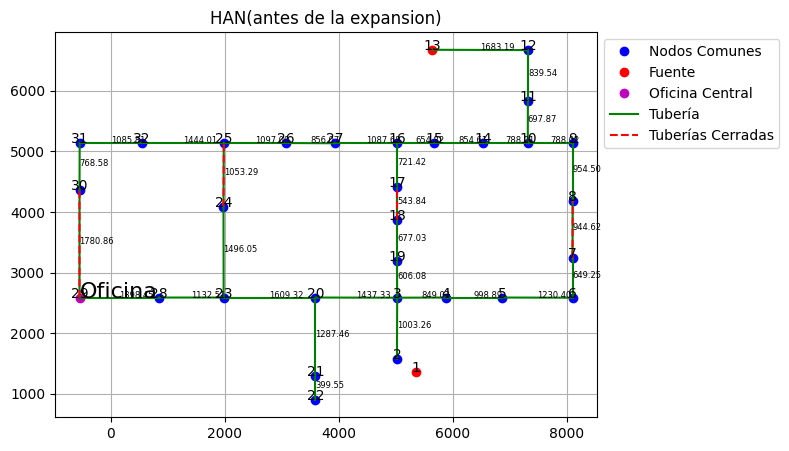


Agregando nuevos nodos:

	Nuevo nodo en (x,y): (8457.0,5177.0) se conecta con 9 en (x,y) -> (8106.66 , 5133.78)
	Nuevo nodo en (x,y): (6478.0,3050.0) se conecta con 5 en (x,y) -> (6873.11 , 2588.3)
	Nuevo nodo en (x,y): (595.0,5929.0) se conecta con 32 en (x,y) -> (536.45 , 5137.63)


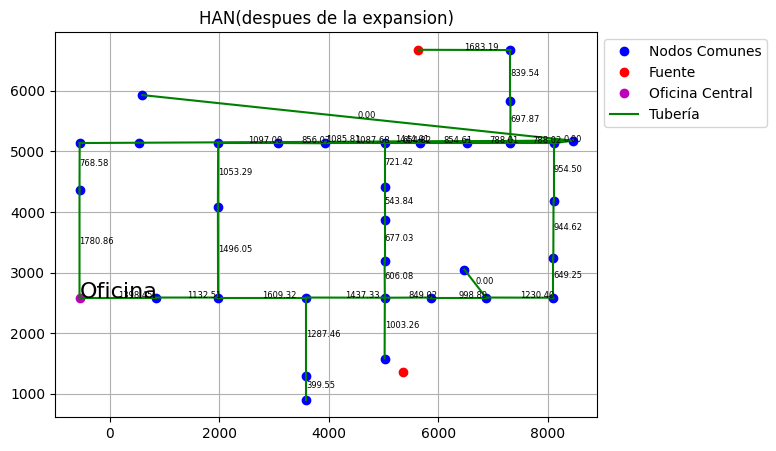


			Procesando archivo: NYT



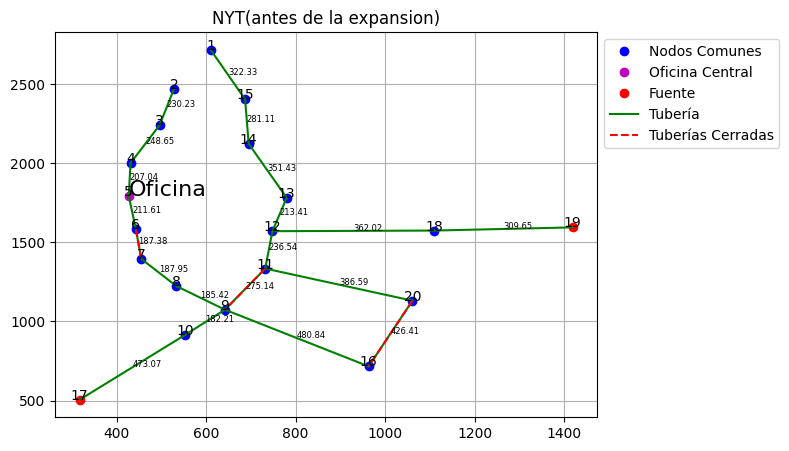


Agregando nuevos nodos:

	Nuevo nodo en (x,y): (930.0,1779.0) se conecta con 13 en (x,y) -> (780.0 , 1781.0)
	Nuevo nodo en (x,y): (6478.0,3050.0) se conecta con 19 en (x,y) -> (1419.0 , 1594.0)
	Nuevo nodo en (x,y): (1269.0,1069.0) se conecta con 20 en (x,y) -> (1061.0 , 1131.0)


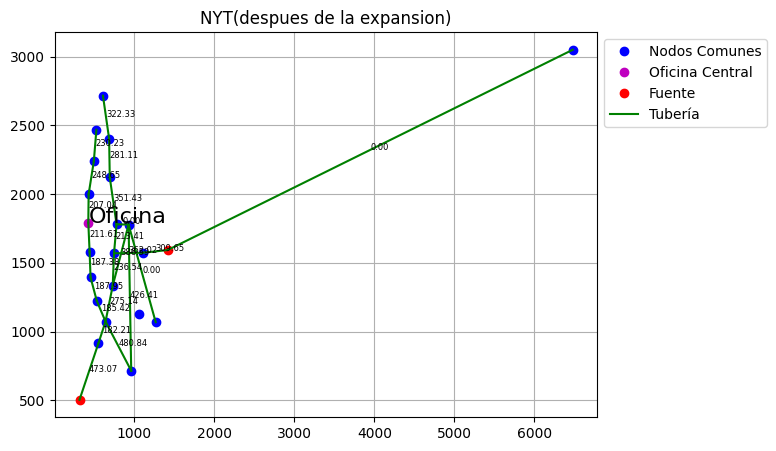


			Procesando archivo: PES



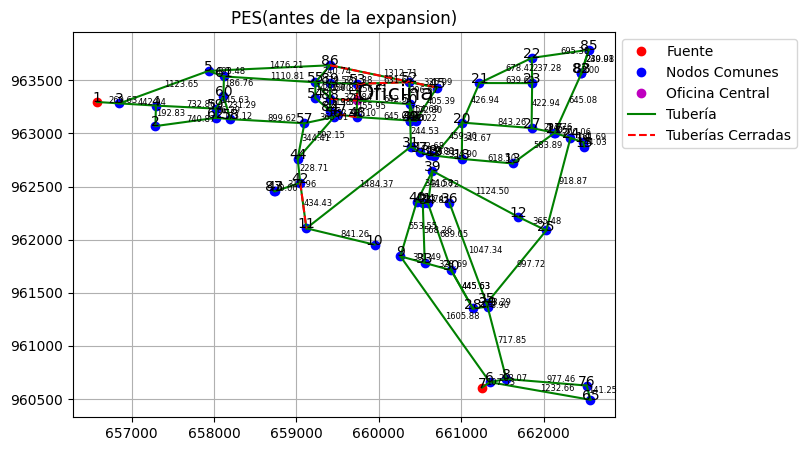


Agregando nuevos nodos:

	Nuevo nodo en (x,y): (657029.0,963601.0) se conecta con 3 en (x,y) -> (656852.19 , 963283.19)
	Nuevo nodo en (x,y): (662127.0,961448.0) se conecta con 25 en (x,y) -> (662031.81 , 962086.69)


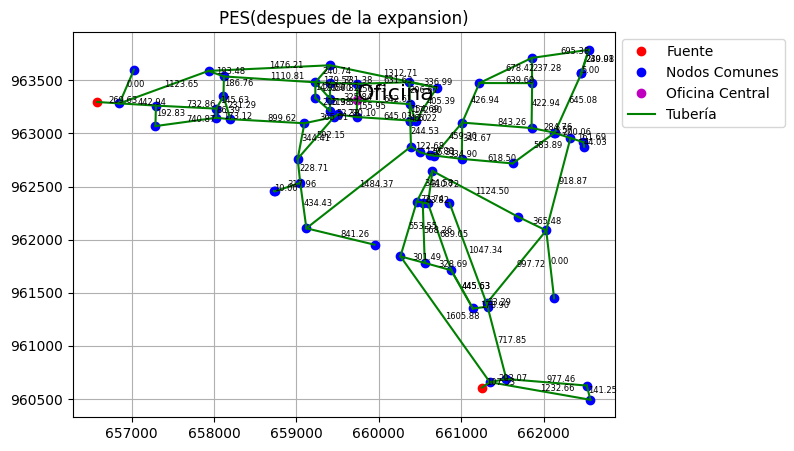

In [15]:
user = "colab"

if user == "misa":
    Files_Routes = ["/Users/misa_v/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/Sem 5/Algoritmos_/SituacionProblema2/FOS.txt",
                    "/Users/misa_v/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/Sem 5/Algoritmos_/SituacionProblema2/HAN.txt",
                    "/Users/misa_v/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/Sem 5/Algoritmos_/SituacionProblema2/NYT.txt",
                    "/Users/misa_v/Library/CloudStorage/OneDrive-InstitutoTecnologicoydeEstudiosSuperioresdeMonterrey/Sem 5/Algoritmos_/SituacionProblema2/PES.txt"]
elif user == "rocco":
    Files_Routes = ["D:\\Tec\\Semestre V\\TC2038 Algoritmos Avanzados\\Code\\SP2\\FOS.txt",
                    "D:\\Tec\\Semestre V\\TC2038 Algoritmos Avanzados\\Code\\SP2\\HAN.txt",
                    "D:\\Tec\\Semestre V\\TC2038 Algoritmos Avanzados\\Code\\SP2\\NYT.txt",
                    "D:\\Tec\\Semestre V\\TC2038 Algoritmos Avanzados\\Code\\SP2\\PES.txt"]
elif user == "colab":
    Files_Routes = ["FOS.txt",
                    "HAN.txt",
                    "NYT.txt",
                    "PES.txt"]

Files_Titles = ["FOS", "HAN", "NYT", "PES"]
Colors = ['b', 'b', 'b', 'b']  # Colores únicos para cada archivo

for idx, route in enumerate(Files_Routes):
    print(f"\n{'='*80}\n\t\t\tProcesando archivo: {Files_Titles[idx]}\n{'='*80}\n")
    nodes_sectores = []
    sinks =[]
    sources = []
    nodos_limpio, tuberias_limpio, new_nodes, id_office = file_prep(route)

    def doEverything(filename, isAntes):
        if isAntes:
          name_txt = filename+"_antes.txt"
        else:
          name_txt = filename+"_despues.txt"

        with open(name_txt, "w") as archivo:

            # Diccionario de nodos
            node_dict = {node.node_id: node for node in nodos_limpio}

            # 2 Distancias
            for tuberia in tuberias_limpio:
                nodo_inicial = node_dict[tuberia.start_node]
                nodo_final = node_dict[tuberia.end_node]

                print("Distancia en tubería entre", tuberia.start_node, "y", tuberia.end_node, ":", tuberia.length, file=archivo)


            # 3
            # Sectorización
            sectores, tuberias_cerradas = sectorize(nodos_limpio, tuberias_limpio)
            print("Sectorización de la topología:\n", file=archivo)
            #print(sectores)
            for sector, nodes in sectores.items():
                nodes_sectores.append(nodes)
                print(f"\tSector asociado a la fuente {sector}: Nodos -> {nodes}", file=archivo)
            print("\nTuberías a cerrar:\n", file=archivo)
            for tuberia in tuberias_cerradas:
                print(f"\tTubería entre {tuberia.start_node} y {tuberia.end_node} con capacidad de {tuberia.capacity}", file=archivo)
                tuberia.open = False

            if isAntes:
                # Configuración de gráfico
                plt.figure(figsize=(7, 5))
                plt.title(Files_Titles[idx] + "(antes de la expansion)")
                for node in nodos_limpio:
                    if node.is_source == 1:
                        plt.plot(node.x, node.y, 'ro', label="Fuente" if "Fuente" not in plt.gca().get_legend_handles_labels()[1] else "")
                    elif node.node_id == id_office:
                        plt.plot(node.x, node.y, 'mo', label="Oficina Central" if "Oficina Central" not in plt.gca().get_legend_handles_labels()[1] else "")
                        plt.text(node.x, node.y, f'Oficina', color='black', fontsize=16)
                    else:
                        plt.plot(node.x, node.y, f'{Colors[idx]}o', label="Nodos Comunes" if "Nodos Comunes" not in plt.gca().get_legend_handles_labels()[1] else "")
                    plt.text(node.x, node.y +0.1, f'{node.node_id}', color='black', fontsize=10, ha='center')

                # Dibujar tuberías y mostrar distancia
                for tuberia in tuberias_limpio:
                    nodo_inicial = node_dict[tuberia.start_node]
                    nodo_final = node_dict[tuberia.end_node]

                    plt.plot([nodo_inicial.x, nodo_final.x], [nodo_inicial.y, nodo_final.y], 'g', label="Tubería" if "Tubería" not in plt.gca().get_legend_handles_labels()[1] else "")
                    plt.text((nodo_inicial.x + nodo_final.x) / 2, (nodo_inicial.y + nodo_final.y) / 2, f'{tuberia.length:.2f}', color='black', fontsize=6)
                for tuberia in tuberias_cerradas:
                    plt.plot([node_dict[tuberia.start_node].x, node_dict[tuberia.end_node].x],
                            [node_dict[tuberia.start_node].y, node_dict[tuberia.end_node].y], 'r--', label="Tuberías Cerradas" if "Tuberías Cerradas" not in plt.gca().get_legend_handles_labels()[1] else "")
                plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
                plt.grid()
                plt.savefig(Files_Titles[idx] + "_antes.png")
                plt.show()

            #4
            # Frescura del Agua
            results_frescura = frescura_agua(nodos_limpio, sectores)
            print("\nNodos más lejanos de cada sector:\n", file=archivo)
            for resultado in results_frescura:

                sinks.append(resultado['nodo_mas_lejano'])
                sources.append(resultado['fuente'])

                print(f"Sector (nodo fuente): {resultado['sector']}, Fuente: {resultado['fuente']}, "
                      f"Nodo más lejano: {resultado['nodo_mas_lejano']}, "
                      f"Distancia: {resultado['distancia']:.2f}", file=archivo)

                print(f"Posicion: {node_dict[resultado['nodo_mas_lejano']].x, node_dict[resultado['nodo_mas_lejano']].y}", file=archivo)

                #print("Flujo máximo de este sector:", end=" ", file=archivo)
                #flujo_maximo = edmonds_karp(nodos_limpio, tuberias_limpio, resultado['fuente'], resultado['nodo_mas_lejano'])
                #print(f"Flujo máximo: {flujo_maximo:.2f}", file=archivo)

            # 5
            # Flujo maximo
            # Ejemplo de uso para cada sector
            print("\nFlujo máximo de cada sector:\n", file=archivo)
            for i in range(len(sources)):
              id_source = sources[i]
              id_sink = sinks[i]
              nodos_del_sector = get_nodes_from_sector(nodos_limpio, nodes_sectores[i])

              # Inicializar el flujo resultante
              flujo_res = flujo_maximo_fun(nodos_limpio, tuberias_limpio, nodos_del_sector, id_source, id_sink)

              # Convertir el flujo a cadena si es necesario
              flujo_string = f"{flujo_res:.2f}"  # Formato con dos decimales

              # Imprimir el resultado en el archivo
              print(f"Sector (nodo fuente): {id_source} a (nodo más lejano) {id_sink}, Flujo máximo: {flujo_string}", file=archivo)

            #6
            #Muestra de agua
            print("\nMuestra de agua:", file=archivo)
            muestras_path, muestras_total_distance = tsp(nodos_limpio, tuberias_limpio, id_office)
            print("Distancia Total:", muestras_total_distance, file=archivo)
            print("Camino:",", ".join(map(str, muestras_path)), file=archivo)

    filename = Files_Titles[idx]
    doEverything(filename, True)

    #7
    # agregando nuevos nodos
    print("\nAgregando nuevos nodos:\n")
    nodos_limpio, tuberias_limpio = expansion_red(new_nodes, nodos_limpio, tuberias_limpio)

    #Hacer todo otra vez
    nodes_sectores = []
    sinks =[]
    sources = []
    filename = Files_Titles[idx]
    doEverything(filename, False)

    #Plot nuevo
    plot_expanded_graph(Files_Titles[idx], nodos_limpio, tuberias_limpio, id_office)


